## Settings

In [1]:
import os
import sys
from sys import platform
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
BASE_PATH = '\\'.join(os.getcwd().split('\\')[:-1]) + '\\' if platform == 'win32' else '/'.join(os.getcwd().split('/')[:-1])
sys.path.append(BASE_PATH+'\src' if platform == 'win32' else BASE_PATH+'/src')
from config.global_config import get_global_config
from utils import get_total_iterations

In [2]:
_config = get_global_config()
HP_CONFIG_PATH = os.path.join(BASE_PATH, _config.get('HP_CONFIG_PATH'))
RESULTS_PATH = os.path.join(BASE_PATH, _config.get('RESULT_PATH'))
if platform == 'win32':
	HP_CONFIG_PATH = HP_CONFIG_PATH.replace('/', '\\')
	RESULTS_PATH = RESULTS_PATH.replace('/', '\\')
EMISSIONS_FILE = 'emissions.csv'
METRICS_FILE = 'metrics.csv'
PARAMS_FILE = 'params.csv'

In [3]:
def get_hp_outcome(dataset):
	experiments = []
	for m in next(os.walk(RESULTS_PATH + dataset))[1]:
		experiments.append(os.path.join(dataset, m))
	experiments = sorted(experiments)

	metrics_list = ['recall@10', 'mrr@10', 'ndcg@10', 'hit@10', 'map@10', 'precision@10', 'gauc', 'itemcoverage@10', 'averagepopularity@10', 'giniindex@10', 'shannonentropy@10']

	results = {'emissions': [], 'duration': [], 'cpu_power': [], 'gpu_power': [], 'ram_power': []}
	metrics = {}
	best = {} # best contains the emissions of the best run by metric for each model
	for m in metrics_list:
		metrics[m] = []
		best[m] = {'emissions': [], 'increments': []}

	for _, v in enumerate(experiments):
		emissions_df = pd.read_csv(os.path.join(RESULTS_PATH, v, EMISSIONS_FILE))
		metrics_df = pd.read_csv(os.path.join(RESULTS_PATH, v, METRICS_FILE))
		e = emissions_df[
			['project_name', 'duration', 'emissions', 'cpu_power', 'gpu_power', 'ram_power']
		].groupby(['project_name']).sum()
		m = metrics_df[['project_name'] + metrics_list].groupby(['project_name']).max()
		if len(e) > 1 or len(m) > 1:
			print('ERROR: len()>1 detected!')
			raise Exception()
		else:
			for k in results.keys():
				if k == 'emissions':
					results[k].append(e.iloc[0][k] * 1000)
				else:
					results[k].append(e.iloc[0][k])
			for k in metrics.keys():
				metrics[k].append(m.iloc[0][k])
				run_id_max = metrics_df.loc[metrics_df[k].idxmax(), 'run_id']
				query = emissions_df[emissions_df['run_id'] == run_id_max]
				best[k]['emissions'].append(query.iloc[0]['emissions'] * 1000)
				best[k]['increments'].append(
					(results["emissions"][-1] - best[k]['emissions'][-1]) / best[k]['emissions'][-1] * 100
				)

	return results, metrics, experiments, best

In [4]:
def print_durations(results, experiments):
	print(''.join(['> ' for i in range(42)]))
	print(f'\n{"ID":<5}{"DATASET":<18}{"MODEL":<10}{"RUNs":>8}{"DURATION":>20}{"AVG DURATION":>18}\n')
	print(''.join(['> ' for i in range(42)]))
	totals = []
	for i, v in enumerate(experiments):
		totals.append(results["duration"][i])
		runs = get_total_iterations(HP_CONFIG_PATH + v.split("/")[1] + ".hyper")
		print(f'\n{i+1:<5}{v.split("/")[0][:12]:<18}{v.split("/")[1]:<10}{runs:>8}{str(datetime.timedelta(seconds=int(results["duration"][i]))):>20}{str(datetime.timedelta(seconds=int(results["duration"][i]/runs)))[2:]:>18}')
		if i > 1 and i == len(experiments) - 1:
			print(f'\n\033[1m{"":<5}{"TOTAL:":<18}{str(datetime.timedelta(seconds=int(sum(totals)))):>36}\033[0m\n')
			totals = []

def print_best_metrics(results, best, experiments):
	print(''.join(['> ' for i in range(50)]))
	print(f'\n{"ID":<5}{"DATASET":<13}{"MODEL":<12}{"BEST_METRIC by INCR.":<20}{"BEST_RUN(g)":>15}{"TOTAL(g)":>15}{"INCREMENT(%)":>15}\n')
	print(''.join(['> ' for i in range(50)]))
	for i, v in enumerate(experiments):
		increments = [best[m]["increments"][i] for m in best.keys()]
		min_keys = [i for i, x in enumerate(increments) if x == min(increments)]
		for j, k in enumerate(best.keys()):
			if j in min_keys:
				print(f'{i+1:<5}{v.split("/")[0][:12]:<13}{v.split("/")[1]:<12}{k:<20}{best[k]["emissions"][i]:>15.4f}{results["emissions"][i]:>15.3f}{best[k]["increments"][i]:15.0f}')
		print('')

In [5]:
def plot_results(results, experiments):
	labels_x2 = [l.split('/')[1] for l in experiments]
	features_to_plot2 = {
		'total_emissions': results['emissions'],
		'avg_emissions': [v / get_total_iterations(HP_CONFIG_PATH + labels_x2[i] + ".hyper") for i, v in enumerate(results['emissions'])]}
	x1 = np.arange(len(labels_x2))  # the label locations
	width = 0.5  # the width of the bars
	multiplier = 0
	fig, axs = plt.subplots(1, 2, figsize=(18, 8))
	for i, v in enumerate(features_to_plot2.keys()):
		for attribute, measurement in [(v, features_to_plot2[v])]:
			offset = width * multiplier
			rects = axs[i].bar(x1 + offset, [round(i, 3) for i in measurement], width, label = attribute)
			axs[i].bar_label(rects, padding = 3)
			multiplier += 1
		axs[i].set_xlabel('Models', fontsize=14)
		axs[i].set_ylabel('Emissions (g)', fontsize=14)
		axs[i].set_title(v.capitalize() + ' by model', fontsize=18)
		axs[i].set_xticks(x1 + (i / 2), labels_x2, rotation = 60, ha="right")
	fig.tight_layout()
	plt.show()

def plot_tradeoff(results, metrics, experiments):
	counter = 0
	l = [['emissions','recall@10'],['emissions','ndcg@10'],['emissions','averagepopularity@10'],['emissions','giniindex@10']]
	fig, axs = plt.subplots(2, 2, figsize=(18, 12))
	for _, axl in enumerate(axs):
		for _, ax in enumerate(axl):
			ax.scatter(results[l[counter][0]], metrics[l[counter][1]], s=80)
			ax.set_title(l[counter][0]+' X '+l[counter][1], fontsize=18)
			ax.set_xlabel(l[counter][0] + ' (g, log base2)', fontsize=14)
			ax.set_ylabel(l[counter][1] + ' (%)', fontsize=14)
			ax.grid()
			for i, (xi, yi) in enumerate(zip(results[l[counter][0]], metrics[l[counter][1]])):
				ax.text(xi+.001, yi+.001, experiments[i].split('/')[1], fontsize=14)
			ax.set_xscale('log', base=2)
			counter = counter + 1
	fig.tight_layout()
	plt.show()

def plot_tradeoff_by_increment(best, experiments):
	counter = 0
	l = ['recall@10', 'ndcg@10', 'averagepopularity@10', 'giniindex@10']
	fig, axs = plt.subplots(2, 2, figsize=(18, 12))
	for _, axl in enumerate(axs):
		for _, ax in enumerate(axl):
			ax.scatter(best[l[counter]]['emissions'], best[l[counter]]['increments'], s=80)
			ax.set_title(l[counter], fontsize=18)
			ax.set_xlabel('best model emissions (g, log base2)', fontsize=14)
			ax.set_ylabel('increment (%)', fontsize=14)
			ax.grid()
			for i, (xi, yi) in enumerate(zip(best[l[counter]]['emissions'], best[l[counter]]['increments'])):
				ax.text(xi+.001, yi+.001, experiments[i].split('/')[1], fontsize=14)
			ax.set_xscale('log', base=2)
			counter = counter + 1
	fig.tight_layout()
	plt.show()

def plot_power(results, experiments):
	labels_x1 = [l.split('/')[1] for l in experiments]
	features_to_plot1 = {'CPU': results['cpu_power'], 'GPU': results['gpu_power'], 'RAM': results['ram_power']}
	x1 = np.arange(len(labels_x1))  # the label locations
	width = 0.2  # the width of the bars
	multiplier = 0
	fig, ax1 = plt.subplots(1, 1, figsize=(18, 8))
	for attribute, measurement in features_to_plot1.items():
		offset = width * multiplier
		rects = ax1.bar(x1 + offset, [round(i, 0) for i in measurement], width, label = attribute)
		ax1.bar_label(rects, padding = 3)
		multiplier += 1
	ax1.set_xlabel('Models', fontsize=14)
	ax1.set_ylabel('Power (W)', fontsize=14)
	ax1.set_title('Power consuption by component', fontsize=18)
	ax1.set_xticks(x1 + (width), labels_x1)
	ax1.legend(loc = 'upper right', ncol = 2)
	fig.tight_layout()
	plt.show()

def plot_increments_by_metrics(best):
	avg_increments = {}
	for i, v in enumerate(best.keys()):
		avg_increments[v] = sum(best[v]['increments']) / len(best[v]['increments'])
	x1 = np.arange(len(list(avg_increments.keys())))  # the label locations
	width = 0.5  # the width of the bars
	multiplier = 0
	fig, ax = plt.subplots(1, 1, figsize=(18, 10))
	for attribute, measurement in [('', list(avg_increments.values()))]:
		offset = width * multiplier
		rects = ax.bar(x1 + offset, [round(i, 0) for i in measurement], width, label = attribute)
		ax.bar_label(rects, padding = 3)
		multiplier += 1
	ax.set_xlabel('Metrics', fontsize=14)
	ax.set_ylabel('Increments (%)', fontsize=14)
	ax.set_title('Avg. increments by metrics', fontsize=18)
	ax.set_xticks(x1, list(avg_increments.keys()), rotation = 60, ha="right")
	fig.tight_layout()
	plt.show()

## Movielens

In [6]:
results, metrics, experiments, best = get_hp_outcome(dataset='movielens_1m')
print_durations(results, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    movielens_1m      BPR             27             2:33:35             05:41

2    movielens_1m      CFKG           162            21:35:43             07:59

3    movielens_1m      CKE            243     1 day, 18:13:35             10:25

4    movielens_1m      DMF             81            17:15:43             12:47

5    movielens_1m      ItemKNN        162             1:25:06             00:31

6    movielens_1m      KGNNLS         162     1 day, 17:50:50             15:29

7    movielens_1m      LINE           162            13:44:13             05:05

8    movielens_1m      LightGCN       216    2 days, 13:13:57             17:00

9    movielens_1m      MultiDAE       162            22:20:33             08:16

10   movielens_1m 

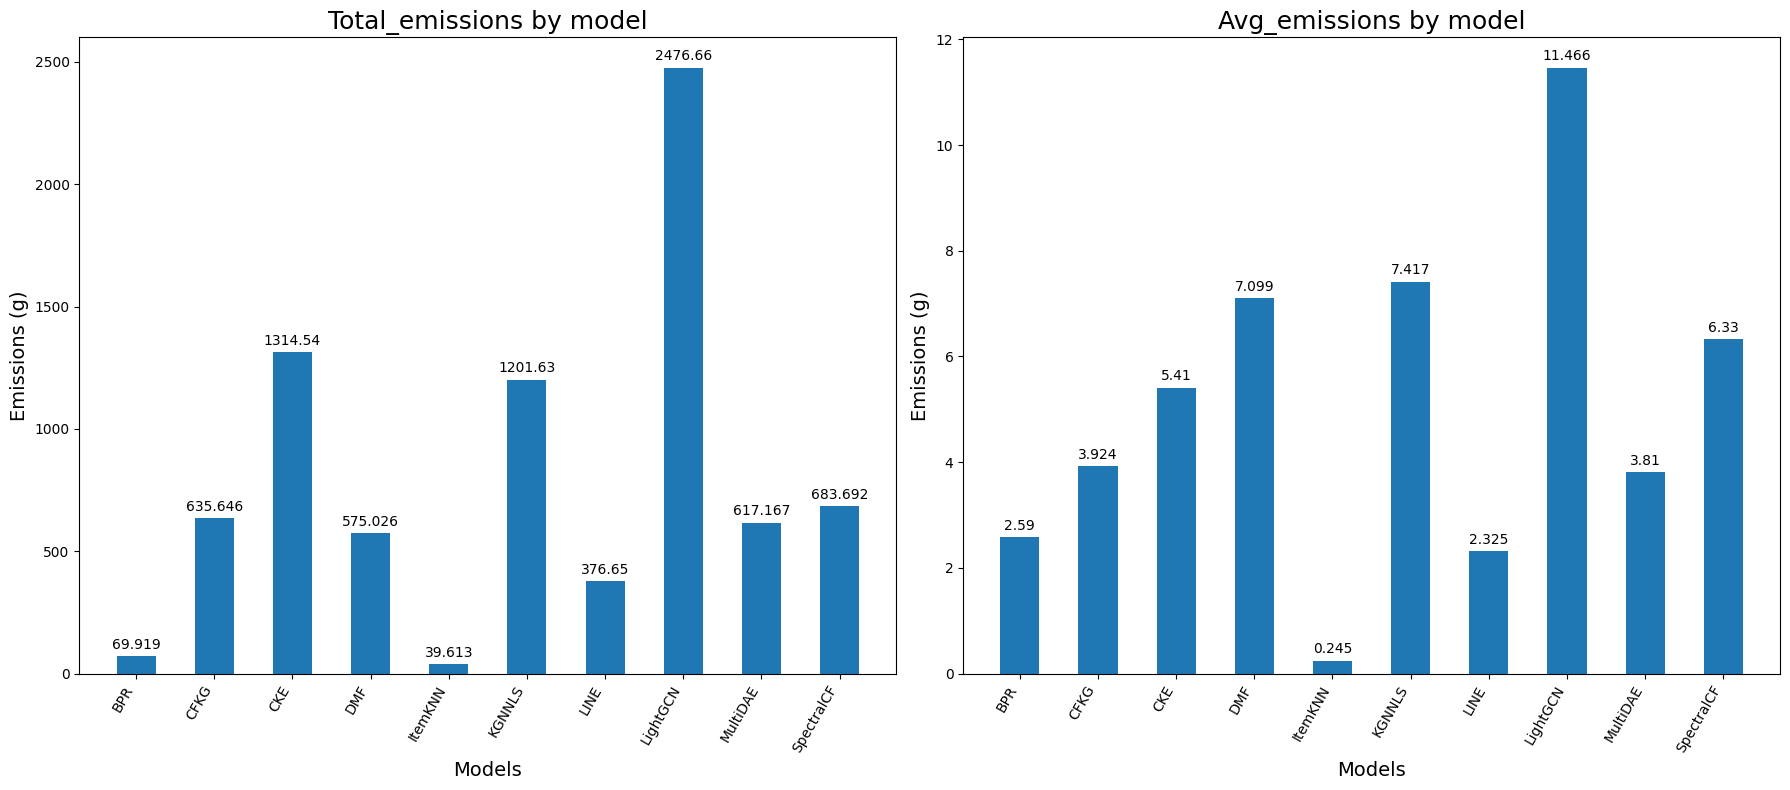

In [7]:
plot_results(results, experiments)

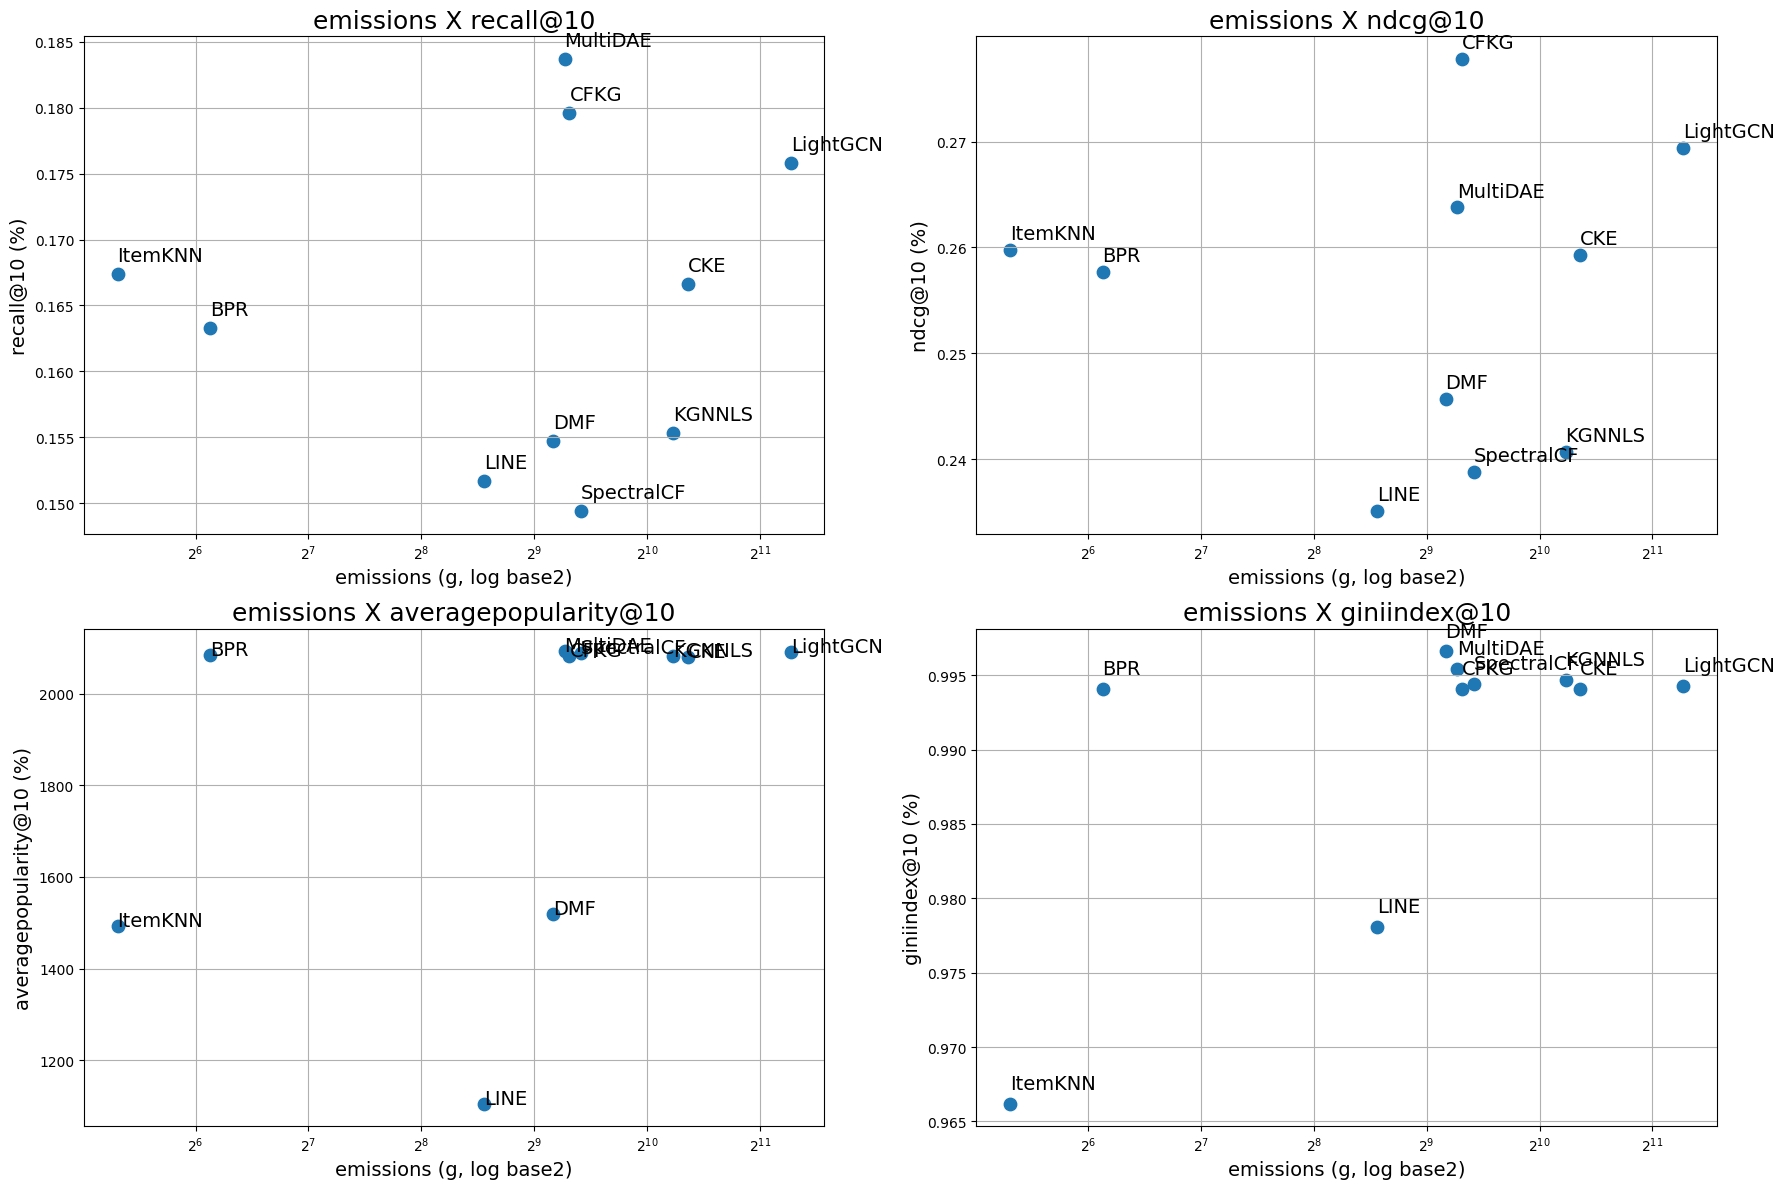

In [8]:
plot_tradeoff(results, metrics, experiments)

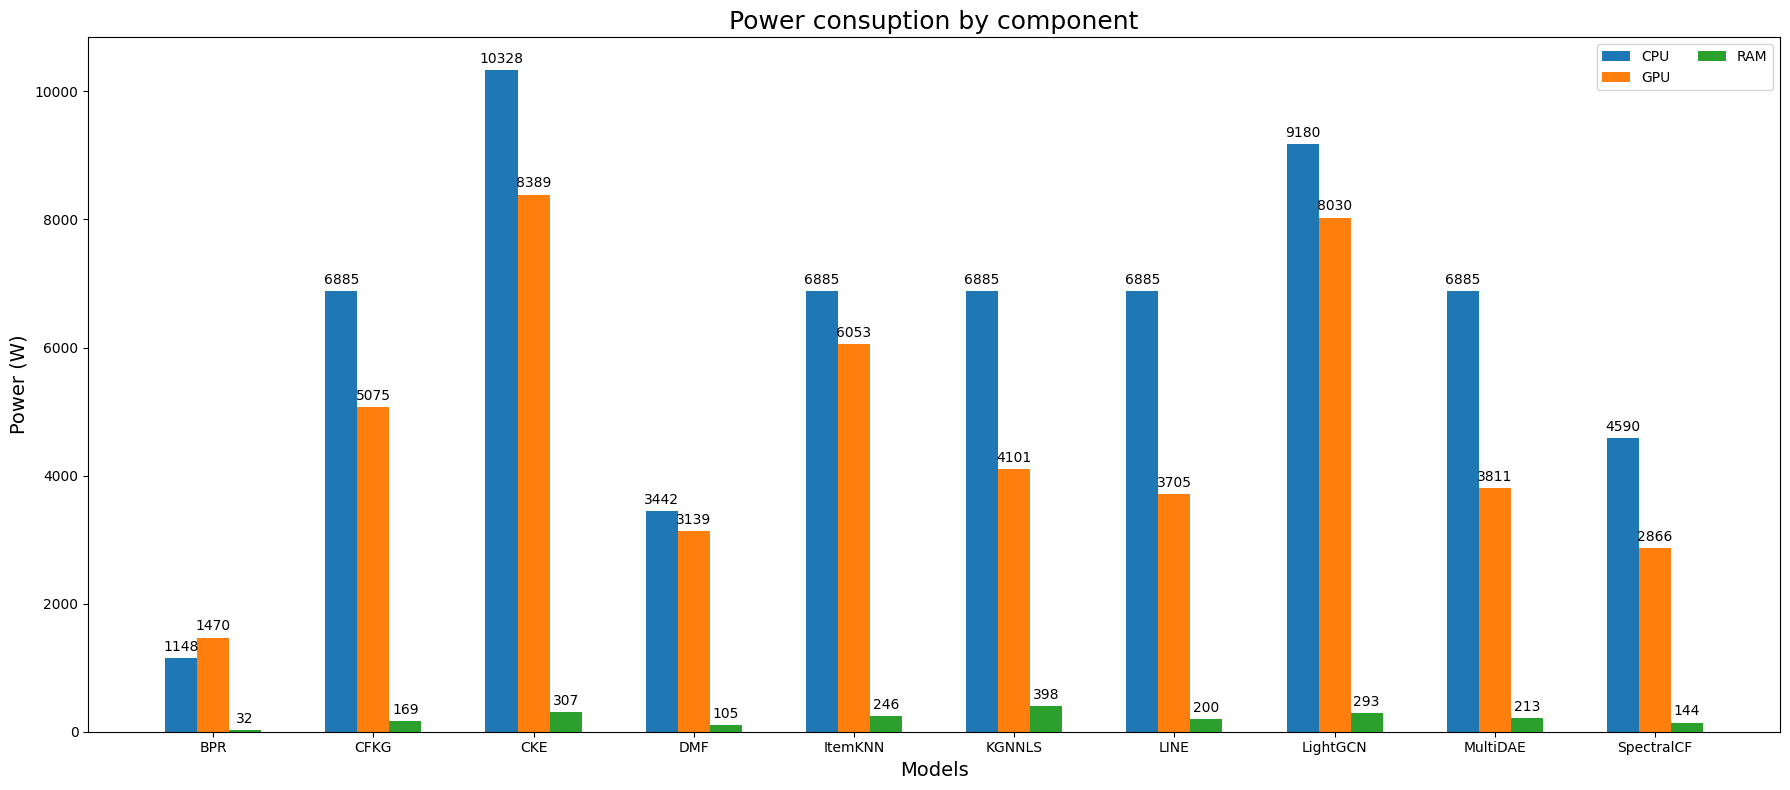

In [9]:
plot_power(results, experiments)

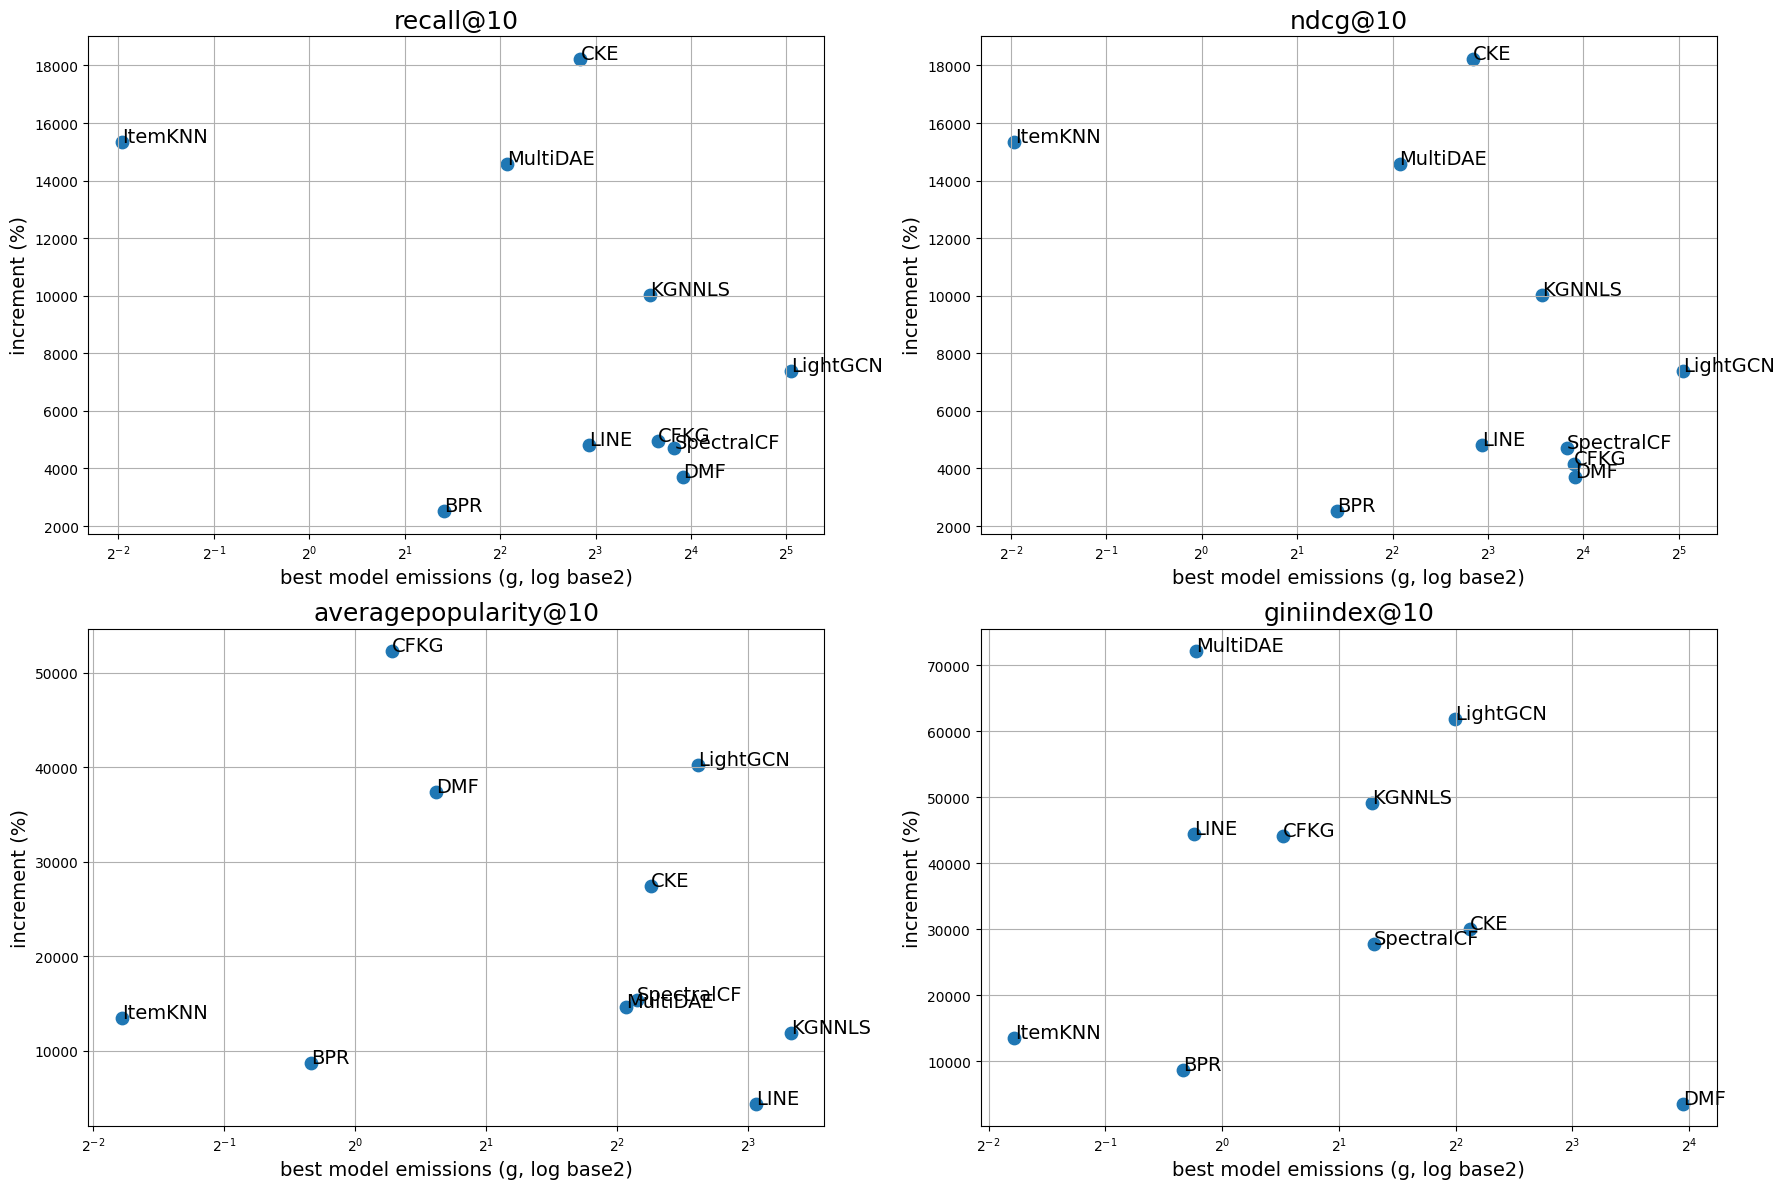

In [10]:
plot_tradeoff_by_increment(best, experiments)

In [11]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    movielens_1m BPR         recall@10                    2.6664         69.919           2522
1    movielens_1m BPR         mrr@10                       2.6664         69.919           2522
1    movielens_1m BPR         ndcg@10                      2.6664         69.919           2522
1    movielens_1m BPR         hit@10                       2.6664         69.919           2522
1    movielens_1m BPR         map@10                       2.6664         69.919           2522
1    movielens_1m BPR         precision@10                 2.6664         69.919           2522
1    movielens_1m BPR         gauc                         2.6664         69.919           2522

2    movielens_1m CFKG     

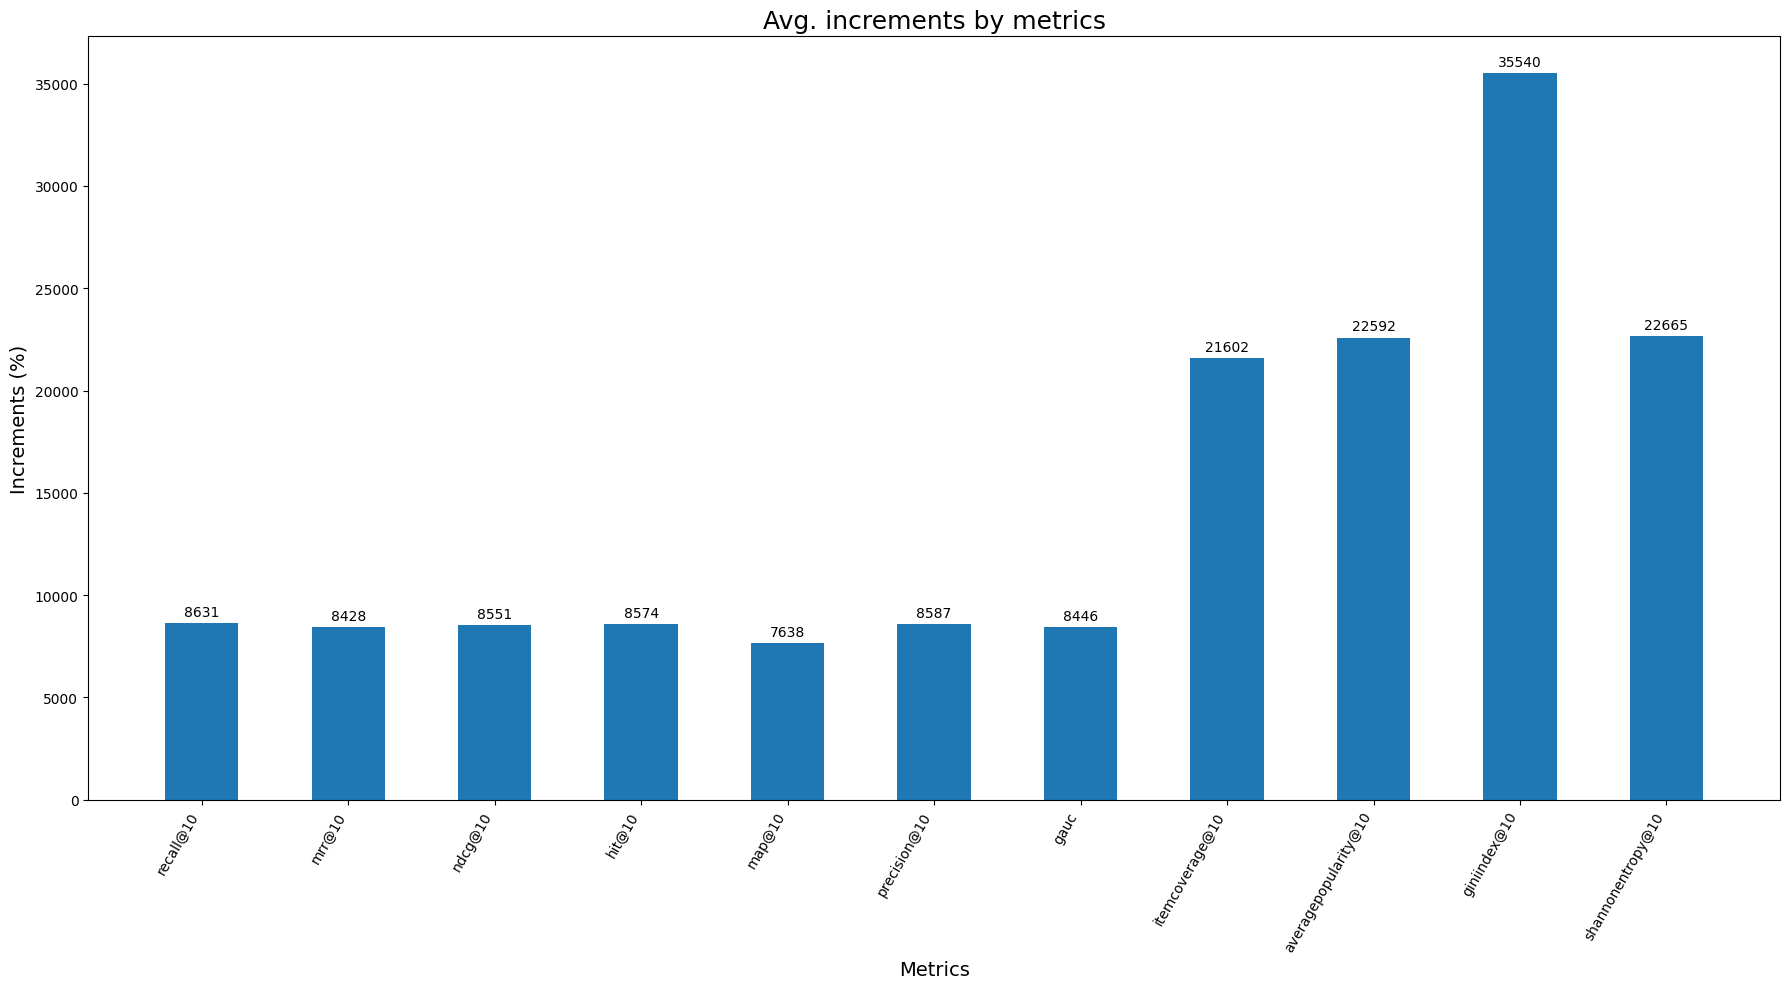

In [12]:
plot_increments_by_metrics(best)

## Mind

In [13]:
results, metrics, experiments, best = get_hp_outcome(dataset='mind')
print_durations(results, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    mind              BPR             27             7:56:17             17:38

2    mind              DMF             81     1 day, 12:52:59             27:19

3    mind              ItemKNN        162             4:58:28             01:50

4    mind              LINE           162     2 days, 0:18:31             17:53

5    mind              LightGCN       216    5 days, 12:44:48             36:52

6    mind              MultiDAE       162     3 days, 9:29:53             30:11

7    mind              SpectralCF     108     1 day, 21:34:11             25:18

     TOTAL:                               14 days, 21:55:12



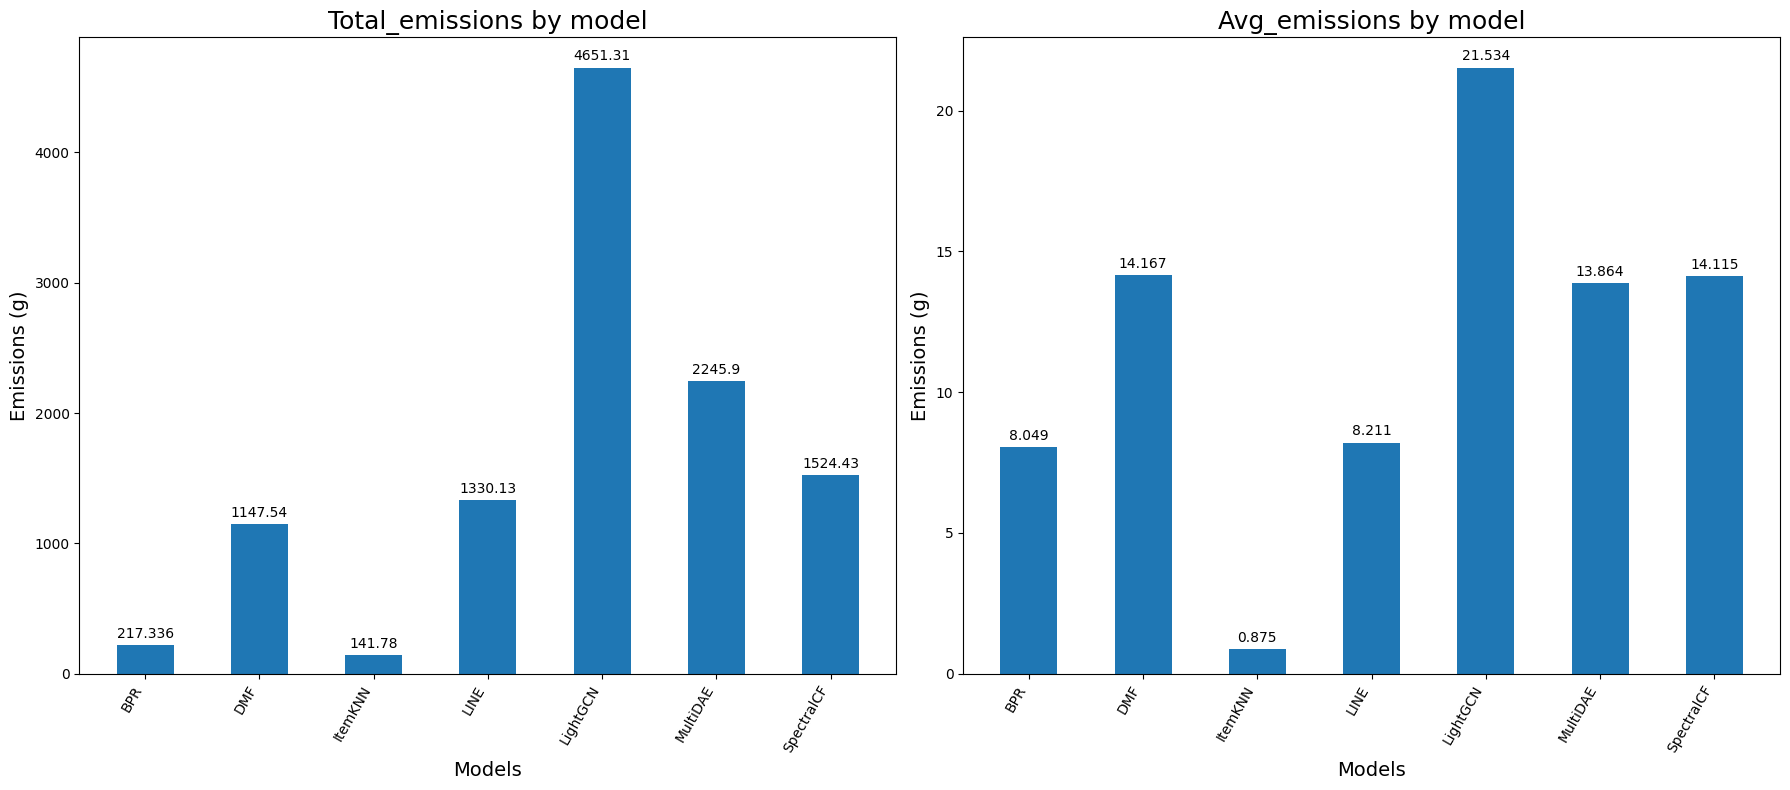

In [14]:
plot_results(results, experiments)

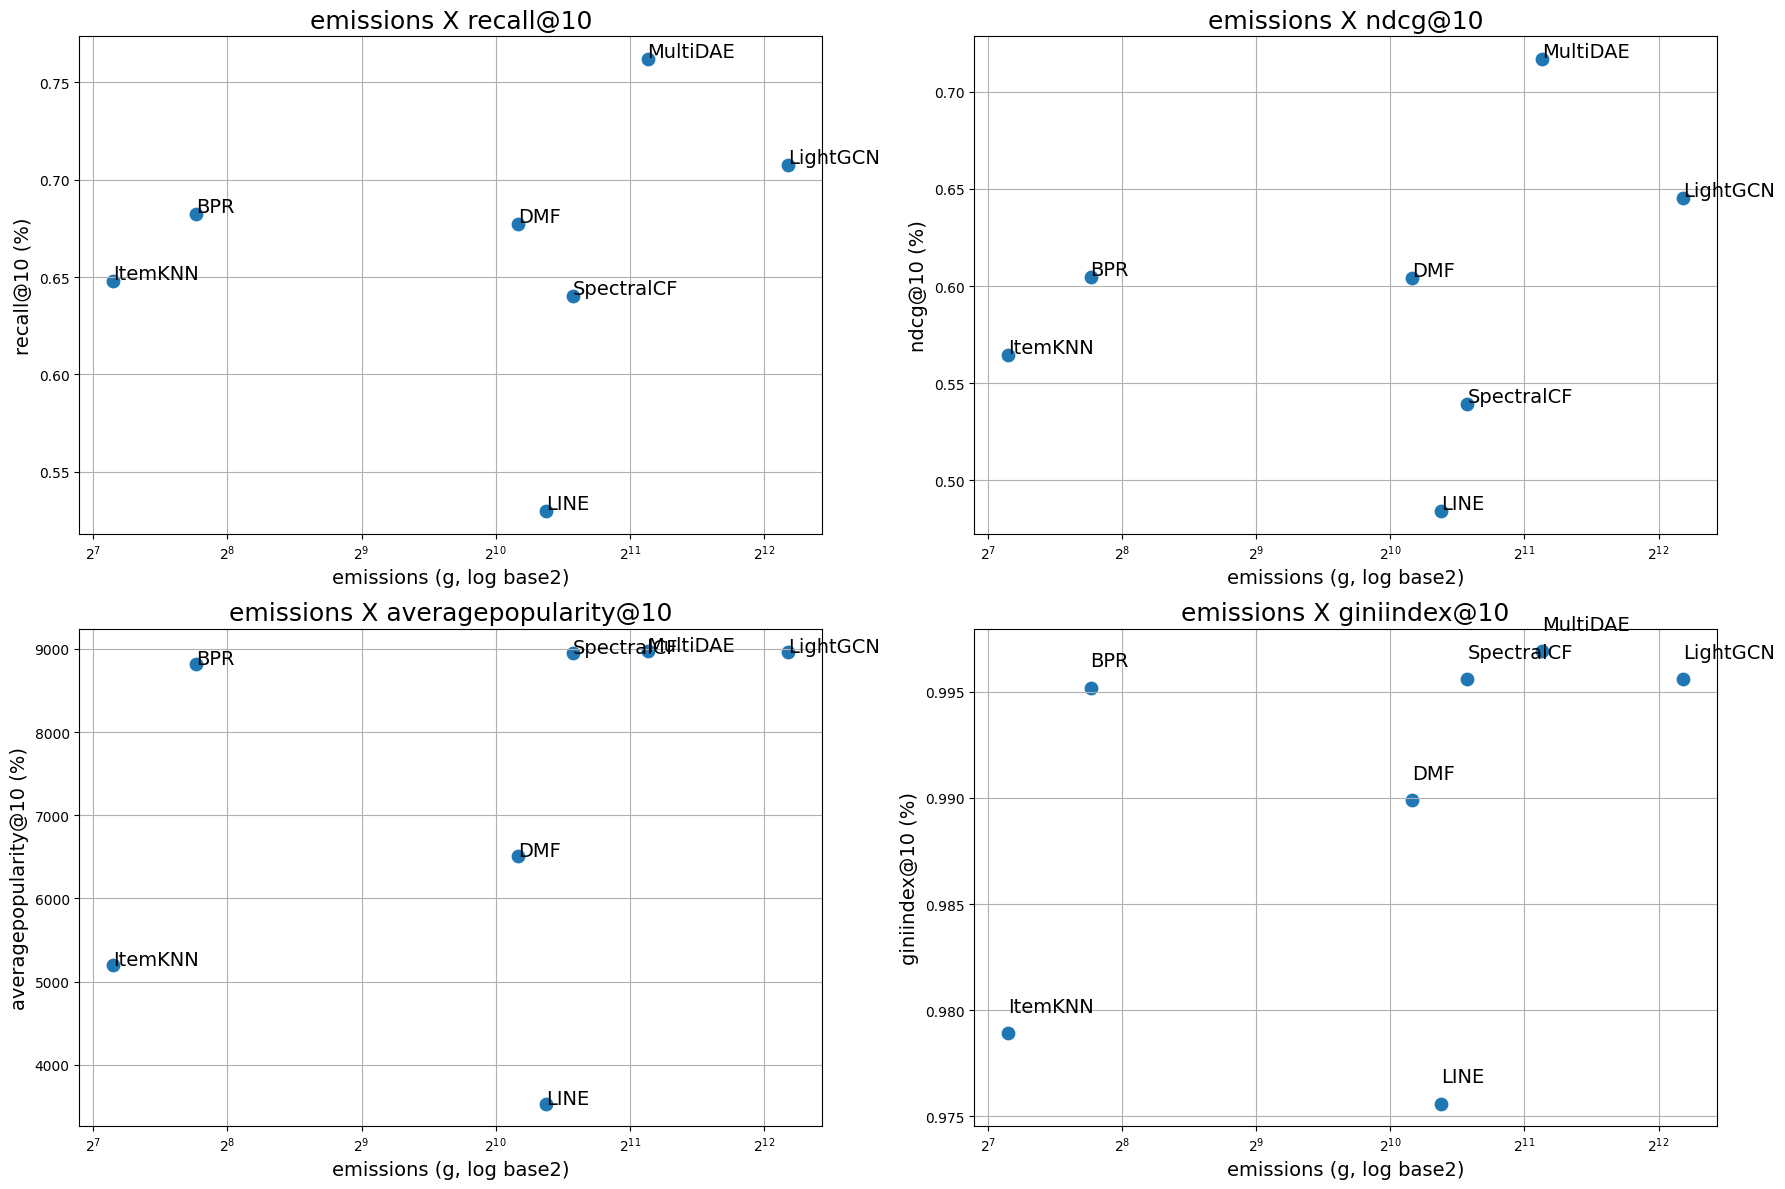

In [15]:
plot_tradeoff(results, metrics, experiments)

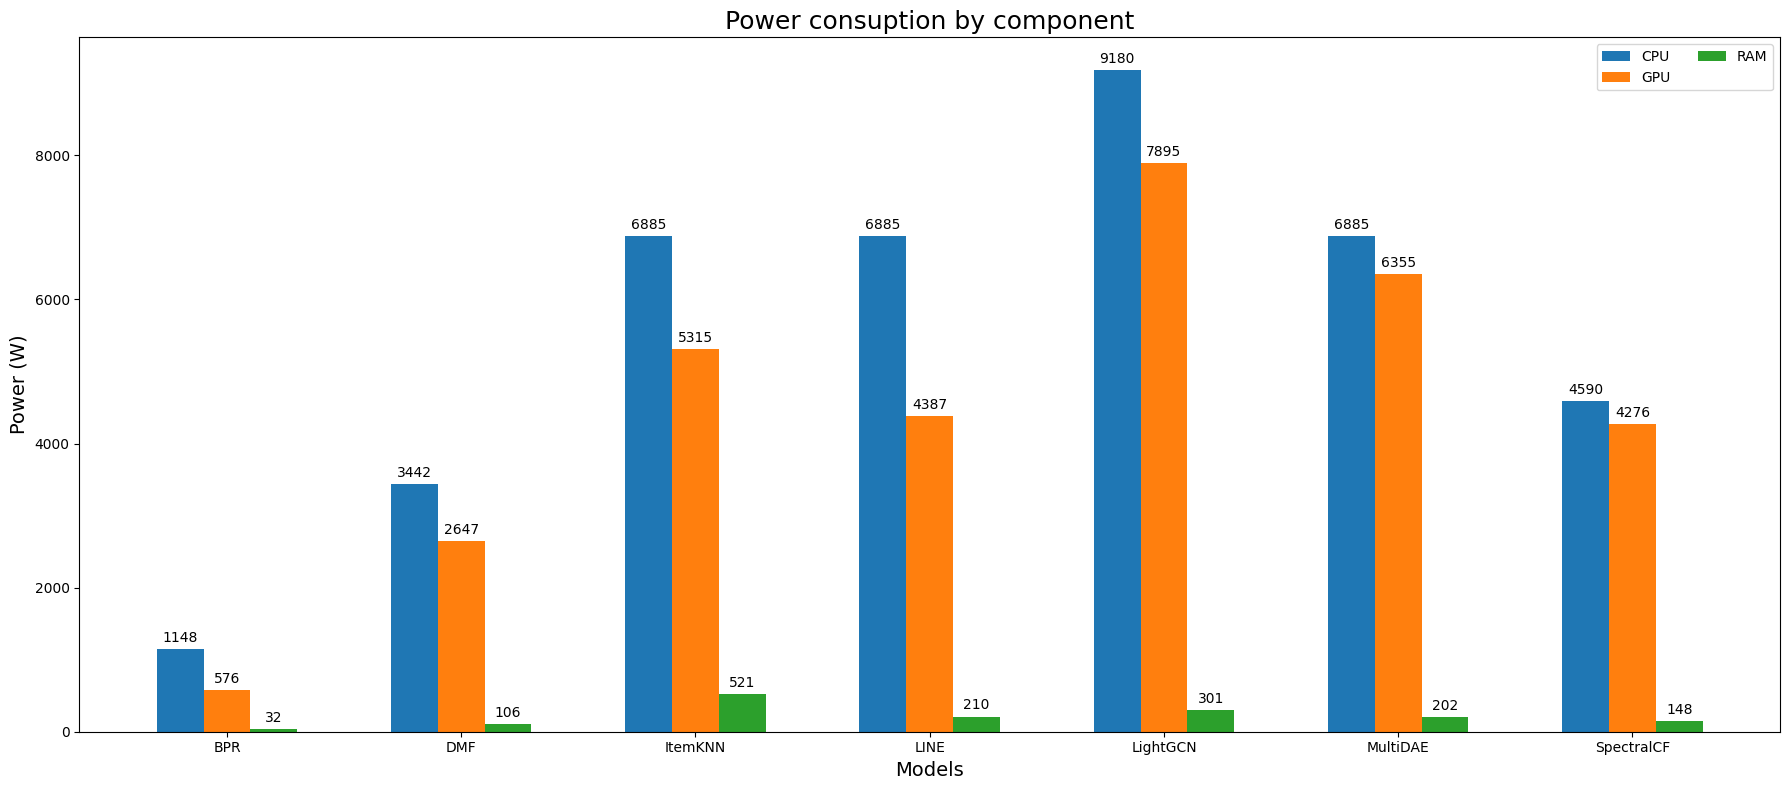

In [16]:
plot_power(results, experiments)

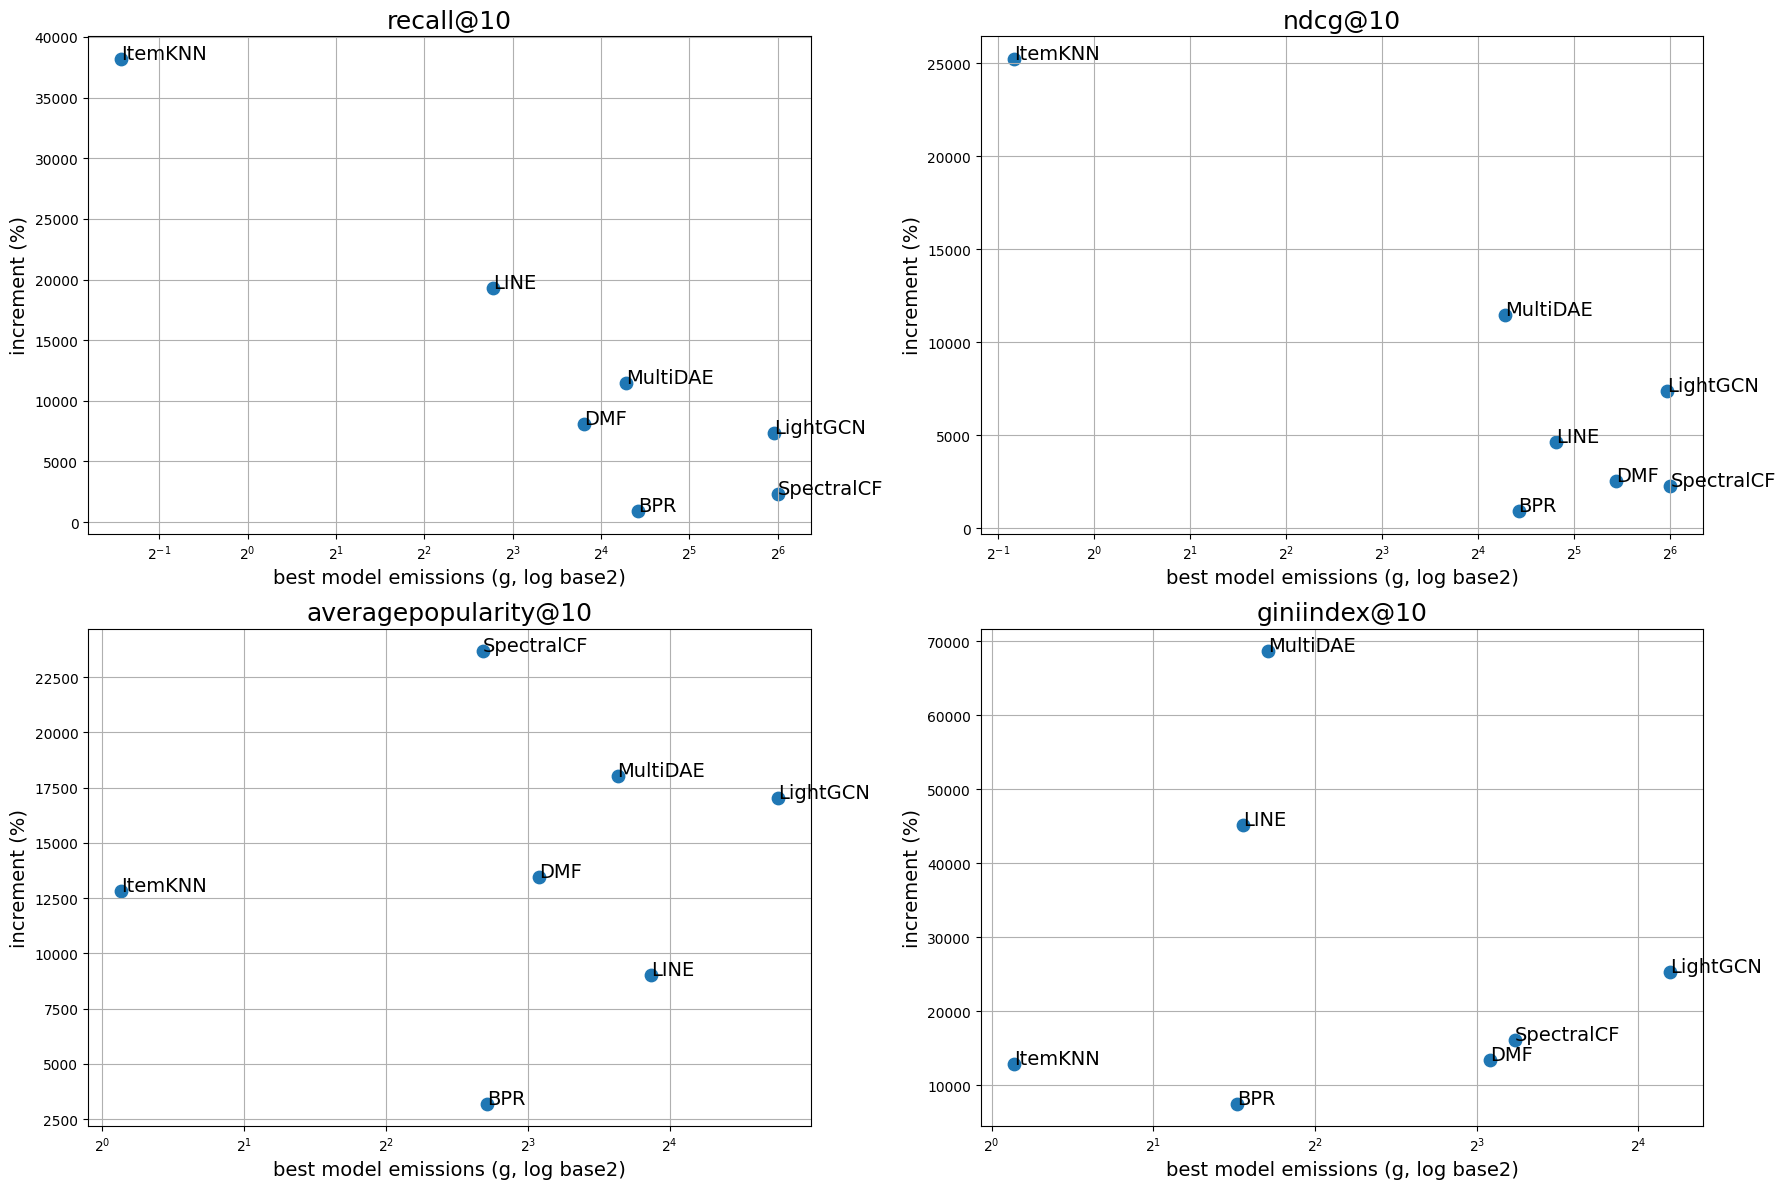

In [17]:
plot_tradeoff_by_increment(best, experiments)

In [18]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    mind         BPR         recall@10                   21.4178        217.336            915
1    mind         BPR         mrr@10                      21.4178        217.336            915
1    mind         BPR         ndcg@10                     21.4178        217.336            915
1    mind         BPR         hit@10                      21.4178        217.336            915
1    mind         BPR         map@10                      21.4178        217.336            915
1    mind         BPR         precision@10                21.4178        217.336            915
1    mind         BPR         gauc                        21.4178        217.336            915

2    mind         DMF      

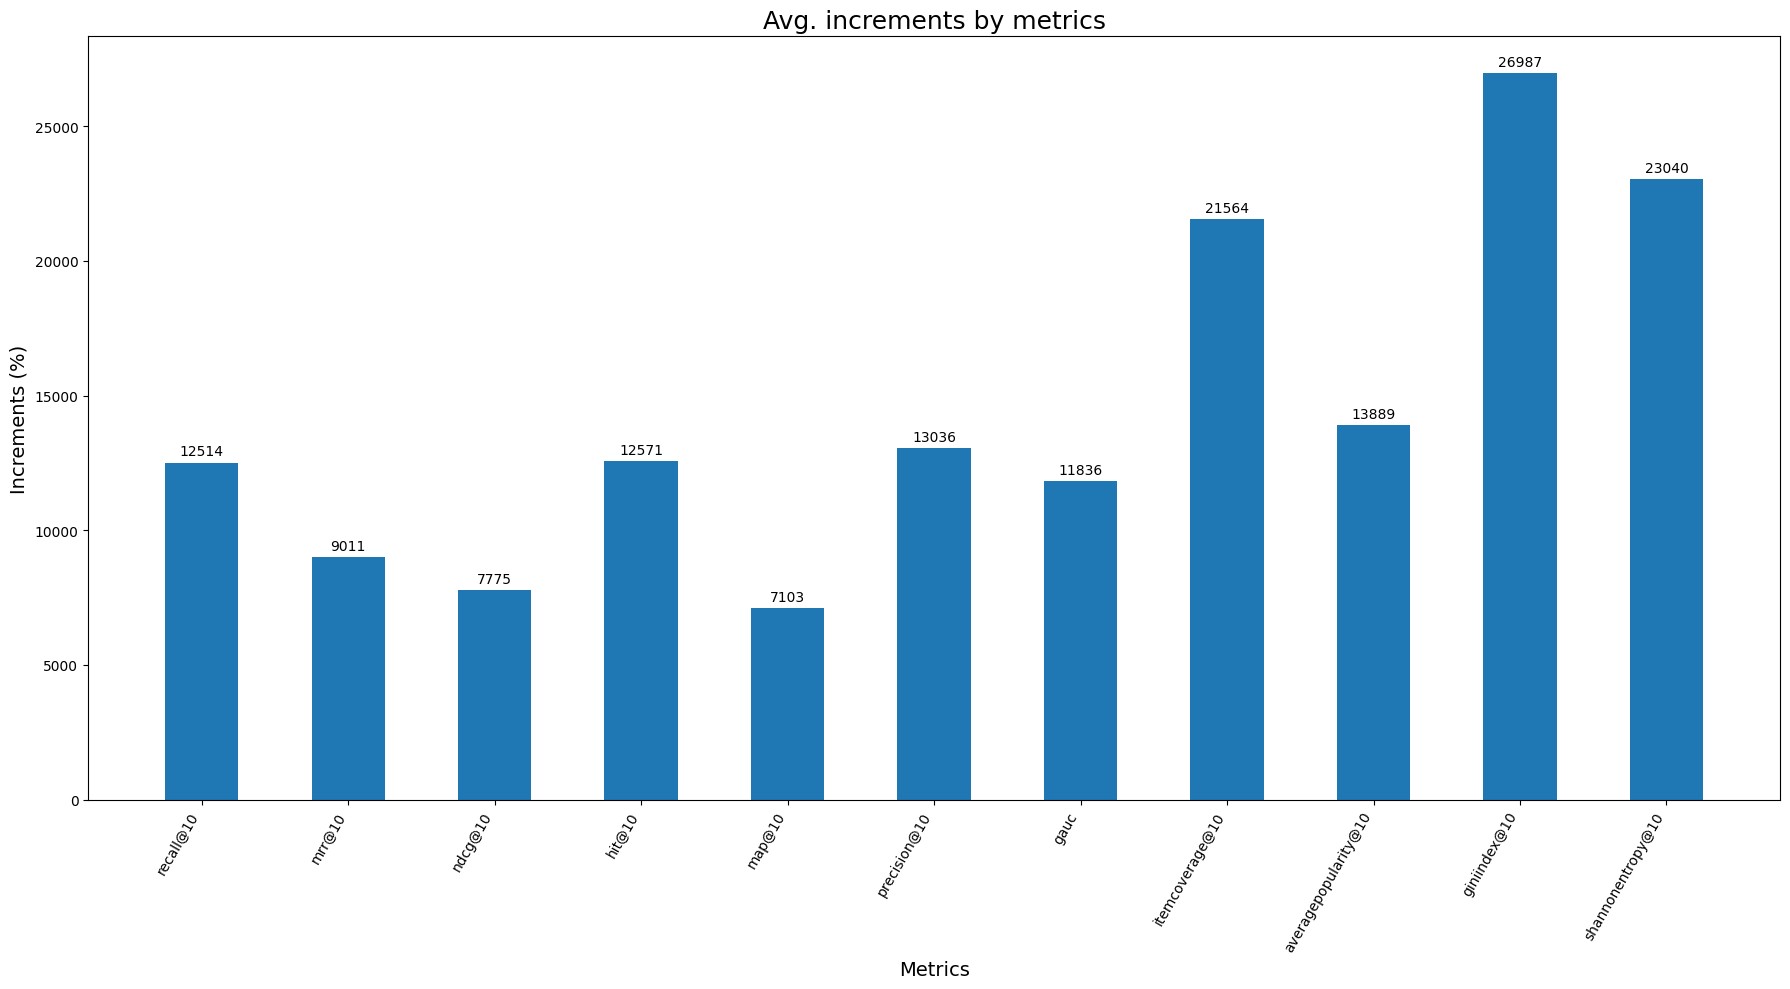

In [19]:
plot_increments_by_metrics(best)

## Amazon Books

In [20]:
results, metrics, experiments, best = get_hp_outcome(dataset='amazon_books_60core_kg')
print_durations(results, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET           MODEL         RUNs            DURATION      AVG DURATION

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

1    amazon_books      BPR             27            19:56:04             44:17

2    amazon_books      CFKG           162     3 days, 8:27:56             29:48

3    amazon_books      CKE            243    3 days, 19:11:17             22:30

4    amazon_books      DMF             81    2 days, 11:52:13             44:20

5    amazon_books      ItemKNN        162            18:54:58             07:00

6    amazon_books      KGNNLS         162     9 days, 1:50:56             20:41

7    amazon_books      LINE           162     4 days, 7:35:54             38:22

8    amazon_books      LightGCN       216   12 days, 18:04:46             25:01

9    amazon_books      MultiDAE       162     5 days, 2:03:14             45:12

10   amazon_books 

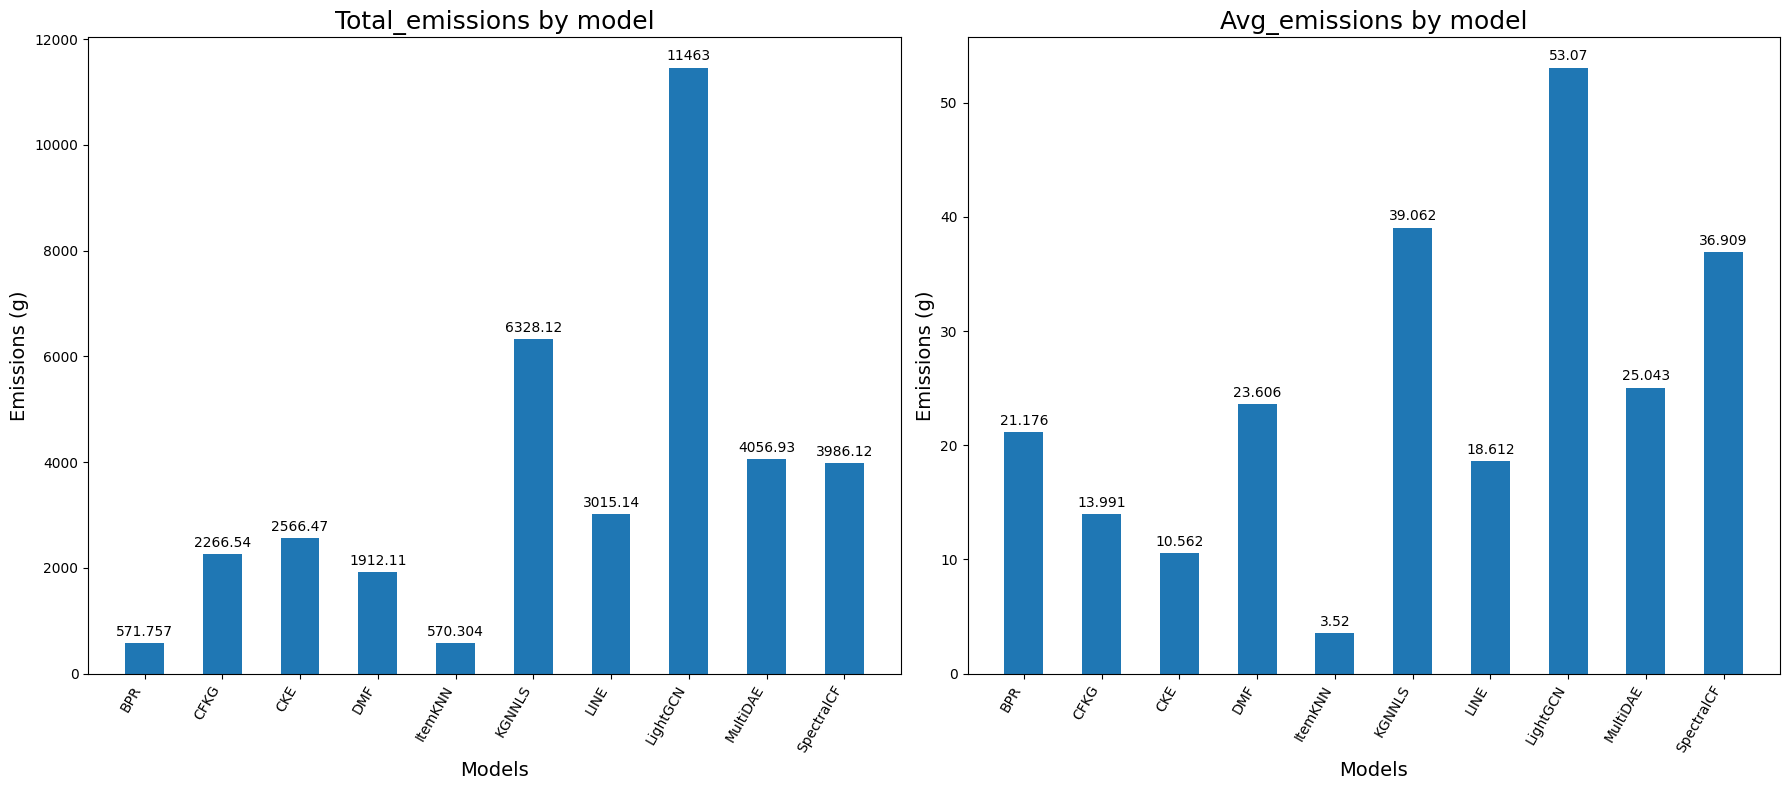

In [21]:
plot_results(results, experiments)

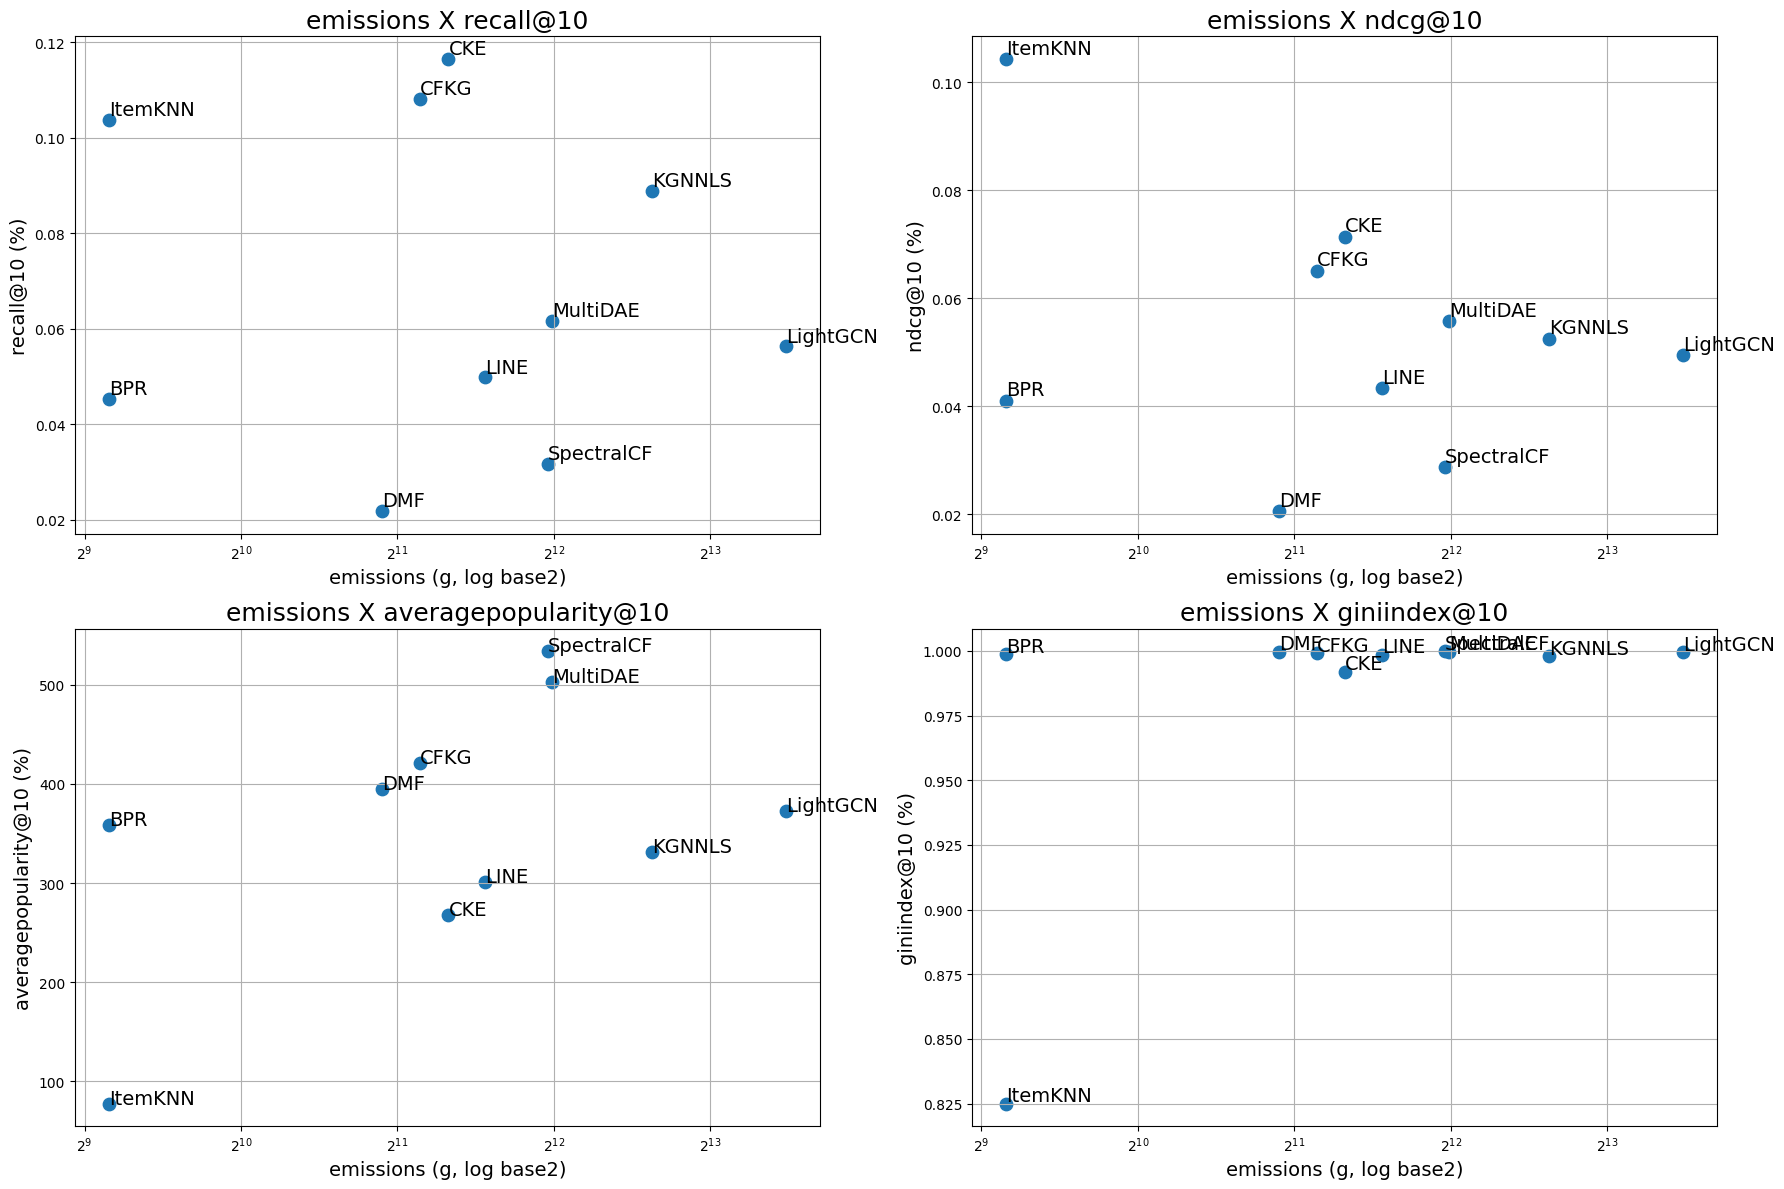

In [22]:
plot_tradeoff(results, metrics, experiments)

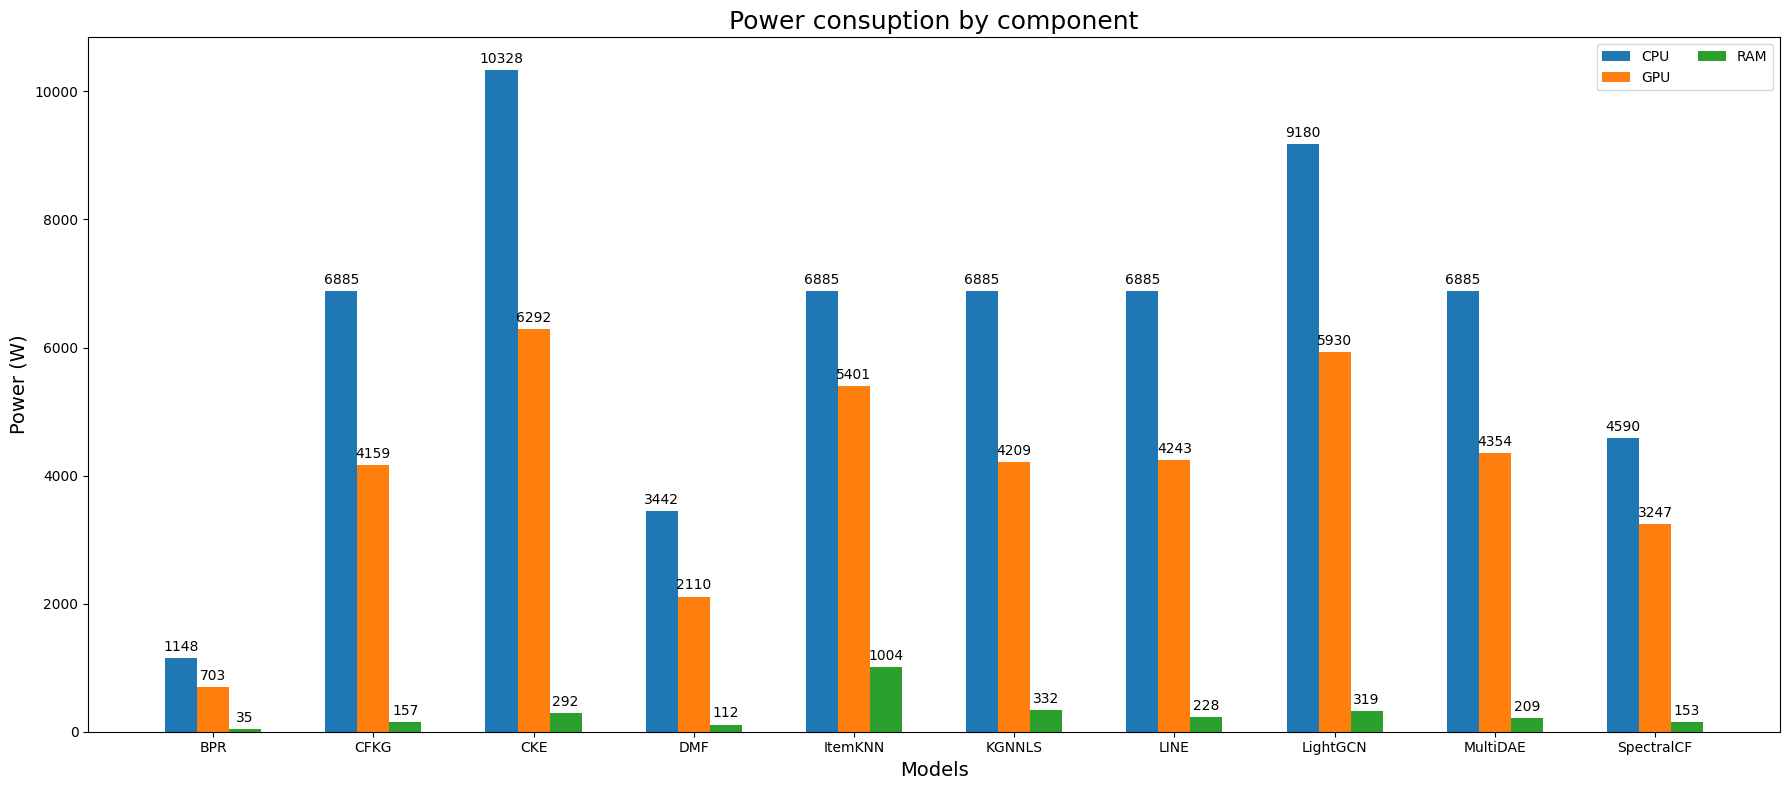

In [23]:
plot_power(results, experiments)

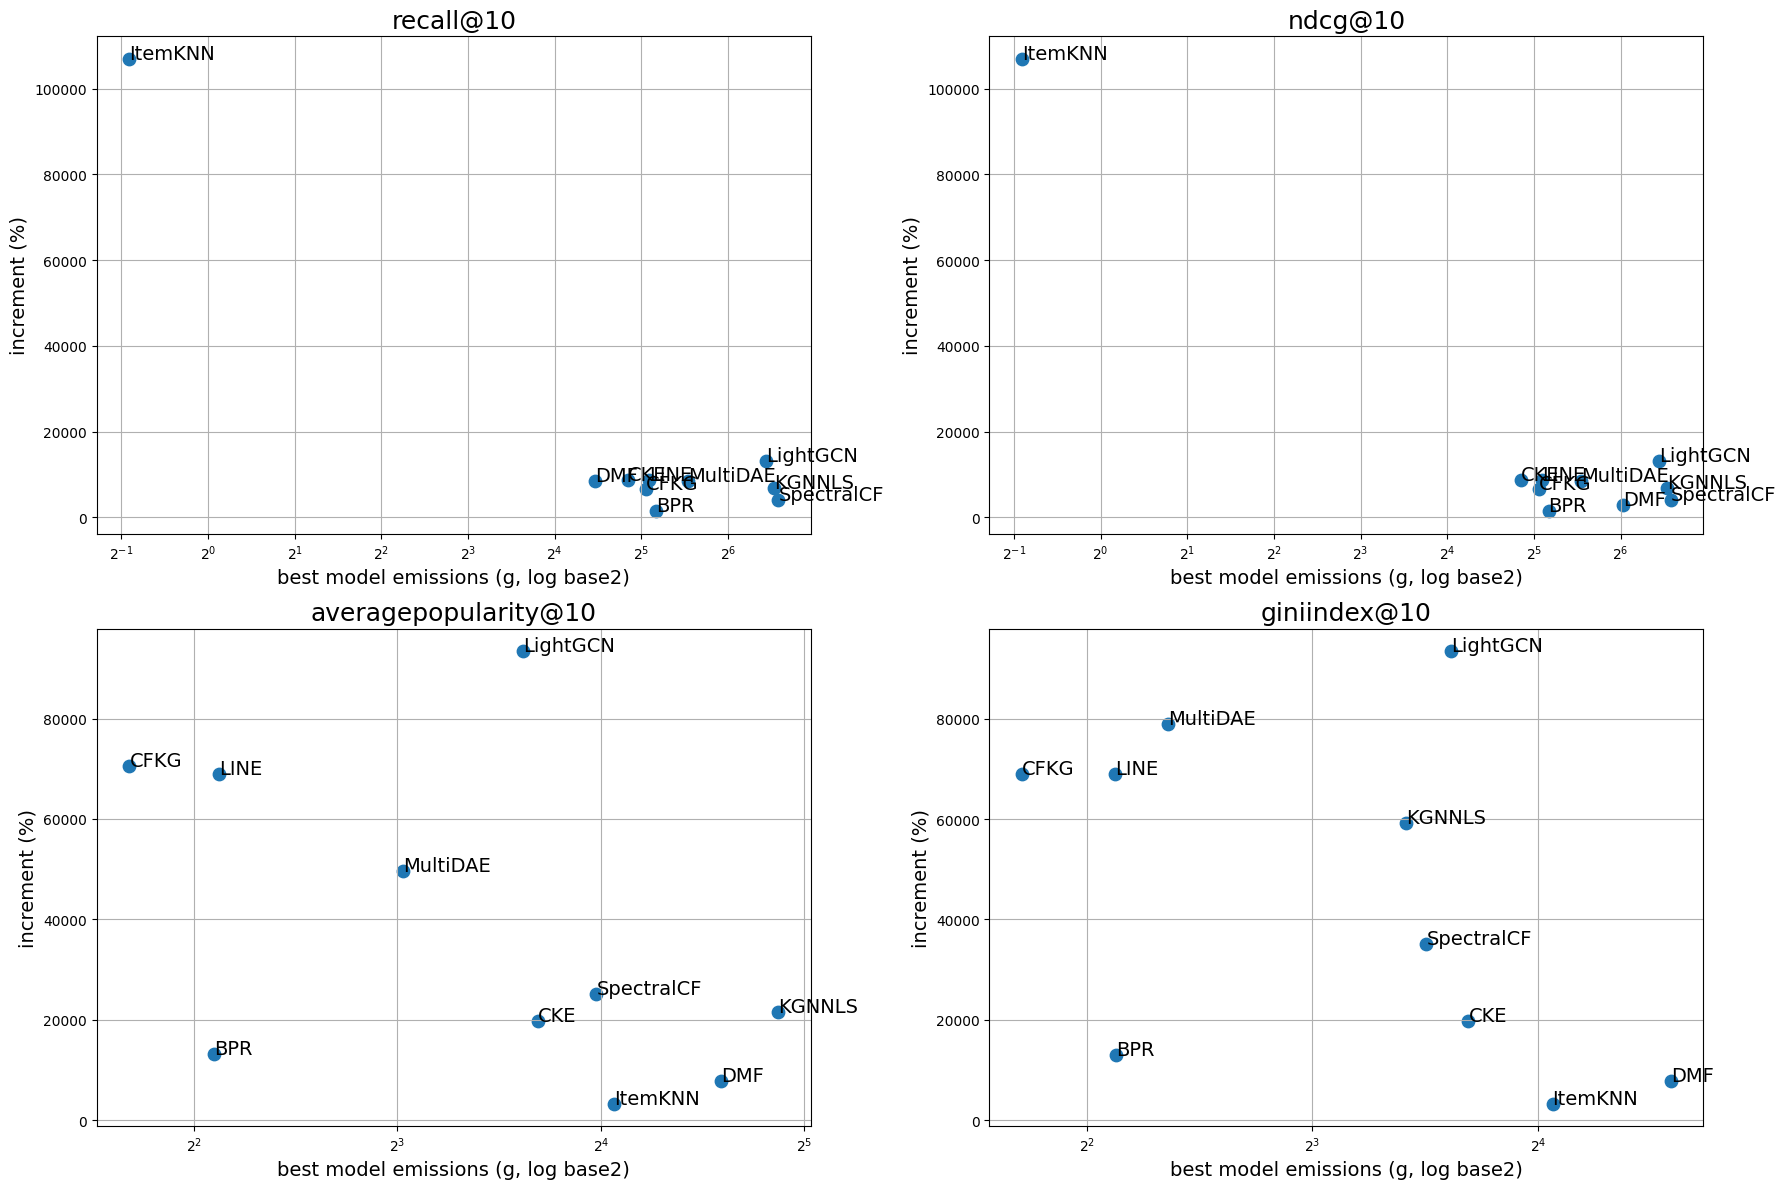

In [24]:
plot_tradeoff_by_increment(best, experiments)

In [25]:
print_best_metrics(results, best, experiments)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 

ID   DATASET      MODEL       BEST_METRIC by INCR.    BEST_RUN(g)       TOTAL(g)   INCREMENT(%)

> > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > > 
1    amazon_books BPR         recall@10                   35.9466        571.757           1491
1    amazon_books BPR         mrr@10                      35.9466        571.757           1491
1    amazon_books BPR         ndcg@10                     35.9466        571.757           1491
1    amazon_books BPR         hit@10                      35.9466        571.757           1491
1    amazon_books BPR         map@10                      35.9466        571.757           1491
1    amazon_books BPR         precision@10                35.9466        571.757           1491

2    amazon_books CFKG        gauc                        33.7018       2266.538           6625

3    amazon_books CKE     

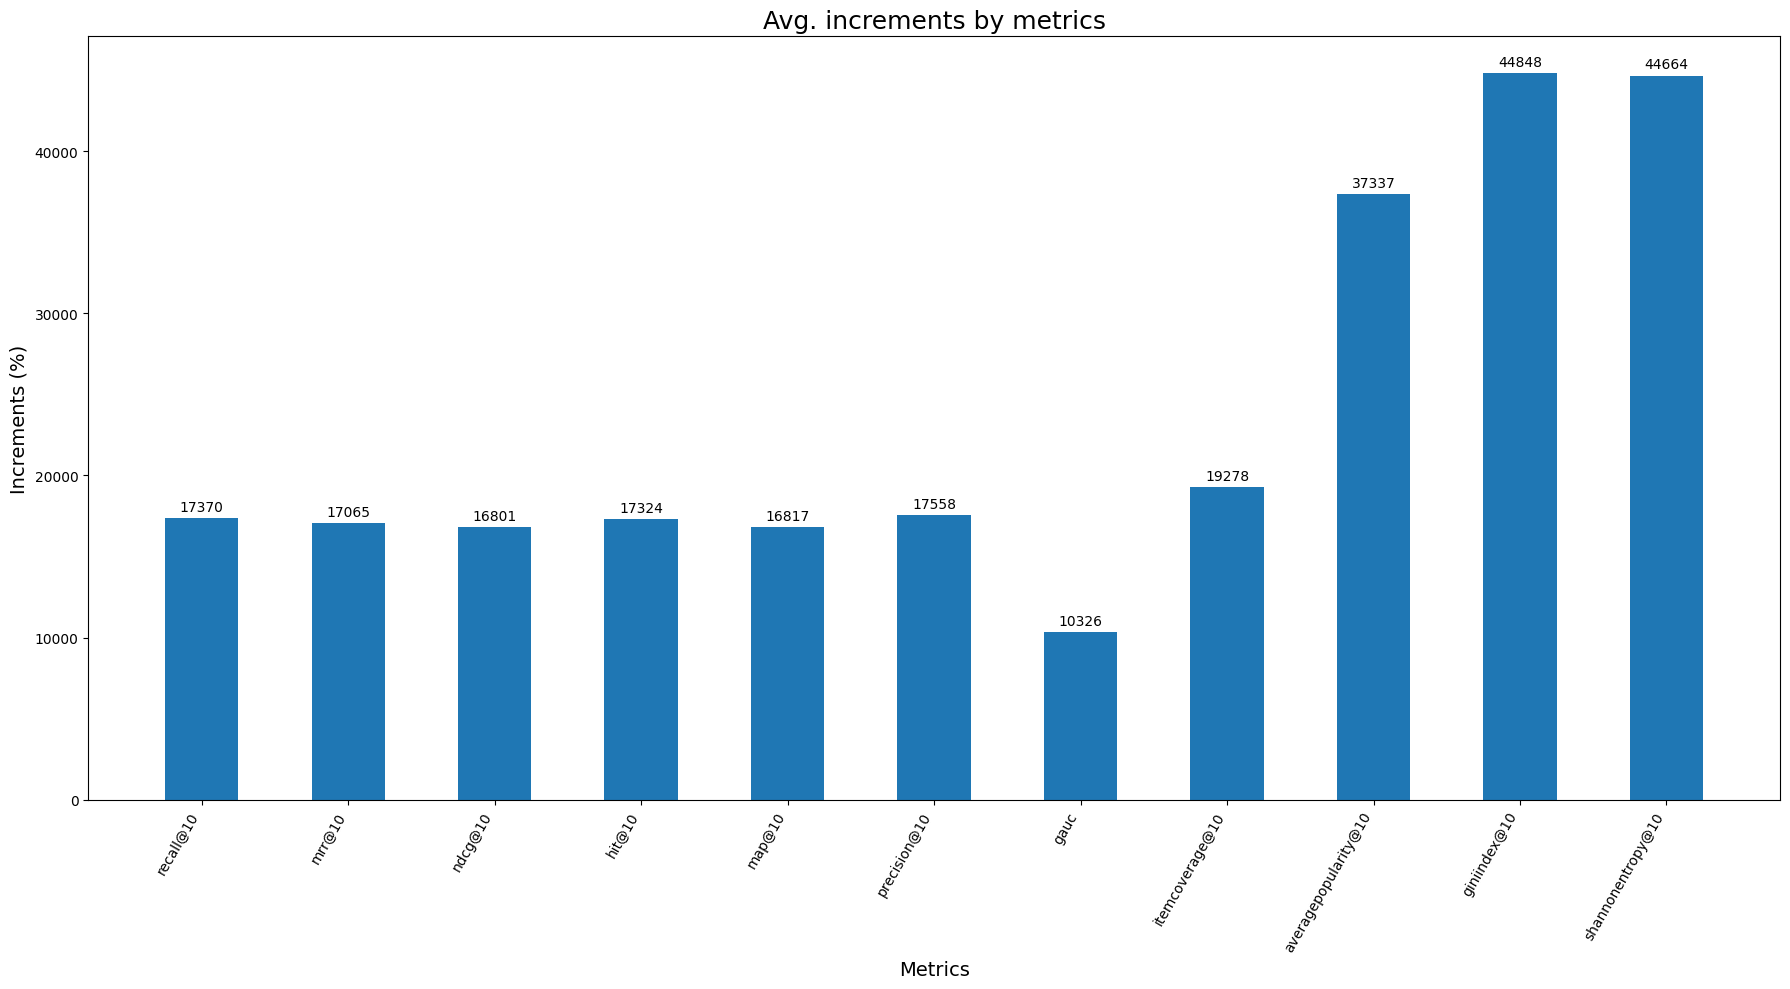

In [26]:
plot_increments_by_metrics(best)